In [12]:
# Example on how to explain a single class for a ResNet50 model from pytorch modelzoo
# This example uses layer4.2 of the model
# Includes running the prediction test for the explanation
# The example is for class 430 (basketball), but can be run for any of the other 1000 classes as well,
# by changing class_to_explain in the cell below to some other class and rerun

In [13]:

class_to_explain = 430

In [ ]:
# load the resnet50 model from pytorch model zoo

from torchvision.models import resnet50
from core.config import DEVICE

DATA_PATH = "data_for_example"

model = resnet50(pretrained=True).to(DEVICE).eval()
layer = model.layer4[2] # we need to manually choose a layer of the model, here we use the last layer convolutional layer of the model, same as we used in the paper

model_name = "resnet50"
layer_name = "_layer4[2]"



In [15]:
# this cell would only need to be run once, changing the class_to_explain does not require to re-run this
# cause here we simply generate the dictionary of concepts from all the imagenet val data, we only need to do this once

from torch.utils.data import DataLoader
# load the imagenet val dataset, we extract the crops for visualizing the concepts from this dataset
from core.imagenet_utils import get_dataset
from example_generate_basis_visualization_from_data_imagenet import sample_closest_image_patches, generate_data_including_prediction

# need to set the PATH_TO_IMAGENET_VAL variable inside core/config.py, so .../imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/
dataset = get_dataset(use_train_ds=False)
dataloader = DataLoader(dataset, shuffle=False, batch_size=128, num_workers=8)

# same params as in the paper, the activations are extracted at the layer and are then run through an average pooling with stride 2 and kernel size 2
activations_all, prediction_classes = generate_data_including_prediction(model, layer, dataloader, kernel_size=2, stride=2, use_average_pooling=True)
prediction_classes = prediction_classes.cpu().numpy()


100%|##########| 391/391 [01:54<00:00,  3.42it/s]


all activations shape: torch.Size([50000, 2048, 3, 3])


In [16]:
import torch
import torch.nn.functional as F
import os
import torchvision
import numpy as np


def get_concept_patches(concept_activation_vectors, activations, image_dataset, is_image_dataset_list=True, n_to_sample=1):
    all_concept_patches = []
    full_images = []
    for component_index in range(len(concept_activation_vectors)):
        concept_patches, full_imgs = sample_closest_image_patches(concept_activation_vectors[component_index], activations, image_dataset, n_to_sample=n_to_sample, is_image_dataset_list=is_image_dataset_list,
                                                                  return_full_imgs_as_well=True)
        all_concept_patches.append(concept_patches)
        full_images.append(full_imgs)

    return torch.cat(all_concept_patches, dim=2), torch.cat(full_images, dim=0)


def get_concept_patches_for_class(class_idx, exclude_target_class_from_patches=False, n_to_sample=1):
    # those nmf basis vectors are precomputed, there are six of them each one representing one concept the model uses to predict the class
    # precomputing them for all 1000 classes takes a bit under a day on a single RTX 2080Ti
    data_path = os.path.join(DATA_PATH, model_name + layer_name, str(class_idx), "nmf", "nmf_basis.pt")
    concept_activation_vectors = torch.load(data_path).to(DEVICE)

    # returns both the normalized images used in get_concept_patches, but finally returns the unnormalized images for plotting
    unnormalized_img_dataset = get_dataset(return_original_sample=True, use_train_ds=False)

    if exclude_target_class_from_patches:
        indices = np.where(prediction_classes != class_idx)[0]
        image_dataset = torch.utils.data.Subset(unnormalized_img_dataset, indices)
        activations = activations_all[indices]
    else:
        image_dataset = unnormalized_img_dataset
        activations = activations_all

    unnormalized_concept_patches, full_imgs = get_concept_patches(concept_activation_vectors, activations, image_dataset, is_image_dataset_list=False, n_to_sample=n_to_sample)

    return unnormalized_concept_patches, full_imgs


def run_prediction_for_concept_patches(class_idx, concept_patches):

    with torch.no_grad():
        pred = F.softmax(model(concept_patches.to(DEVICE)), dim=1)
        pred_class = torch.mean(pred[:, class_idx])
        max_class = torch.argmax(torch.mean(pred, dim=0))
        max_pred = torch.max(torch.mean(pred, dim=0))

        print("class idx: {}".format(class_idx))
        print("pred class: {}, max_class: {}, max_pred: {}".format(pred_class, max_class, max_pred))



class idx: 430
pred class: 0.9999923706054688, max_class: 430, max_pred: 0.9999923706054688
torch.Size([1, 3, 444, 74])


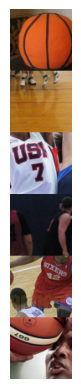

In [17]:
import matplotlib.pyplot as plt

# generate n_to_sample=8 examples per concept. Allow to sample patches from class_to_explain (the class we wish to explain)
unnormalized_concept_patches, _ = get_concept_patches_for_class(class_idx=class_to_explain, n_to_sample=8, exclude_target_class_from_patches=False)

unnormalized_concept_patches_ = unnormalized_concept_patches

# only use the first example
normalized_concept_patches = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(unnormalized_concept_patches[0].unsqueeze(dim=0))

run_prediction_for_concept_patches(class_to_explain, normalized_concept_patches)
print(normalized_concept_patches.shape) # 1, 3, 444, 74 -> each concept example has a size of 74x74

plt.axis('off')
plt.imshow(unnormalized_concept_patches.cpu()[0].permute(1, 2, 0))

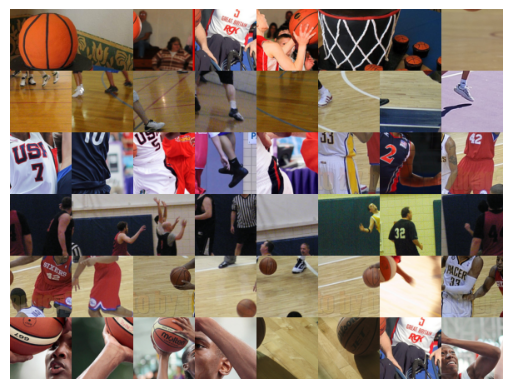

In [18]:
import matplotlib.pyplot as plt

# plot all 8 examples
unnormalized_concept_patches = torch.cat([unnormalized_concept_patches[i] for i in range(len(unnormalized_concept_patches))], dim=-1)
plt.axis('off')
plt.imshow(unnormalized_concept_patches.cpu().permute(1, 2, 0))

# the first concept looks like a basketball (at least in the very first image), the second looks like legs on a gym floor, the third looks like trikots,
# the fourth looks like people without trikots, the fourth looks like a basketball over a matte gym floor and the last looks like a two colored basketball held in hands
# before throwing it

class idx: 430
for full images: pred class: tensor([1.8890e-06, 1.2542e-07, 4.8732e-03, 1.8890e-06, 5.8681e-02, 2.8765e-07,
        3.5561e-07, 4.1587e-07, 1.2290e-04, 1.2290e-04, 1.2952e-06, 6.2052e-06,
        1.2952e-06, 6.2052e-06, 6.8017e-03, 1.2290e-04, 1.1833e-01, 1.1833e-01,
        1.6073e-02, 1.1833e-01, 1.6073e-02, 1.3542e-04, 1.1367e-06, 1.2842e-01,
        1.2934e-01, 1.9443e-02, 1.1070e-10, 1.2934e-01, 6.8017e-03, 3.7925e-05,
        4.2512e-05, 2.4148e-03, 1.7866e-03, 3.1770e-07, 5.7636e-05, 3.7384e-06,
        6.6492e-08, 3.7384e-06, 3.7384e-06, 8.9920e-05, 4.3450e-05, 4.3450e-05,
        3.5561e-07, 2.5487e-01, 1.6756e-08, 1.2224e-03, 8.9920e-05, 3.5316e-06],
       device='cuda:0'), max_class: tensor([417, 417, 673, 417, 727, 417, 808, 417, 752, 752, 752, 752, 752, 752,
        890, 752, 890, 890, 890, 890, 890, 981, 981, 768, 890, 890, 702, 890,
        890, 890, 422, 722, 910, 641, 522, 910, 910, 910, 910, 420, 768, 768,
        808, 890, 900, 768, 420, 890], device

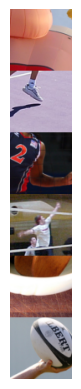

In [19]:
# same as above, but now do not allow to sample the concept patches from dataset images where the model predicts the class we wish to explain
# (i.e. only sample from images where the model does not predict class_to_explain)
# this works a bit worse compared to allowing the class we wish to explain, but makes a stronger point if it works

import matplotlib.pyplot as plt

# generate n_to_sample=8 examples per concept. Only sample the patches from images where the model is not predicting class_to_explain
unnormalized_concept_patches, full_imgs = get_concept_patches_for_class(class_idx=class_to_explain, n_to_sample=8, exclude_target_class_from_patches=True)

normalized_imgs = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(full_imgs)

with torch.no_grad():
    pred = F.softmax(model(normalized_imgs.to(DEVICE)), dim=1)
    pred_class = pred[:, class_to_explain]
    max_class = torch.argmax(pred, dim=1)

    print("class idx: {}".format(class_to_explain))
    print("for full images: pred class: {}, max_class: {}".format(pred_class, max_class)) # double check that the model does not predict class_to_explain as majority class for any of the full images, just to be sure...

# only use the first example
normalized_concept_patches = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(unnormalized_concept_patches[0].unsqueeze(dim=0))
run_prediction_for_concept_patches(class_to_explain, normalized_concept_patches) # here we now want it to predict class_to_explain, since we pass it the image combined from the crops

unnormalized_concept_patches_non_target = unnormalized_concept_patches[0].unsqueeze(dim=0)

plt.axis('off')
plt.imshow(unnormalized_concept_patches.cpu()[0].permute(1, 2, 0))

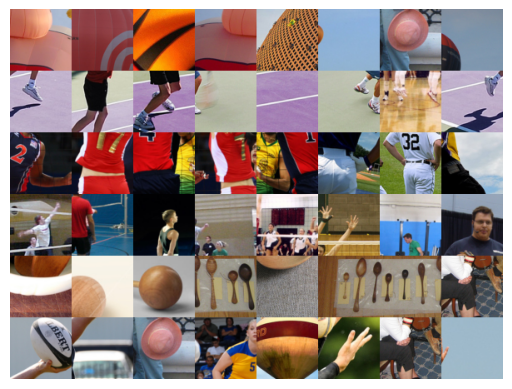

In [20]:
import matplotlib.pyplot as plt

# plot all 8 examples

unnormalized_concept_patches = torch.cat([unnormalized_concept_patches[i] for i in range(len(unnormalized_concept_patches))], dim=-1)
plt.axis('off')
plt.imshow(unnormalized_concept_patches.cpu().permute(1, 2, 0))

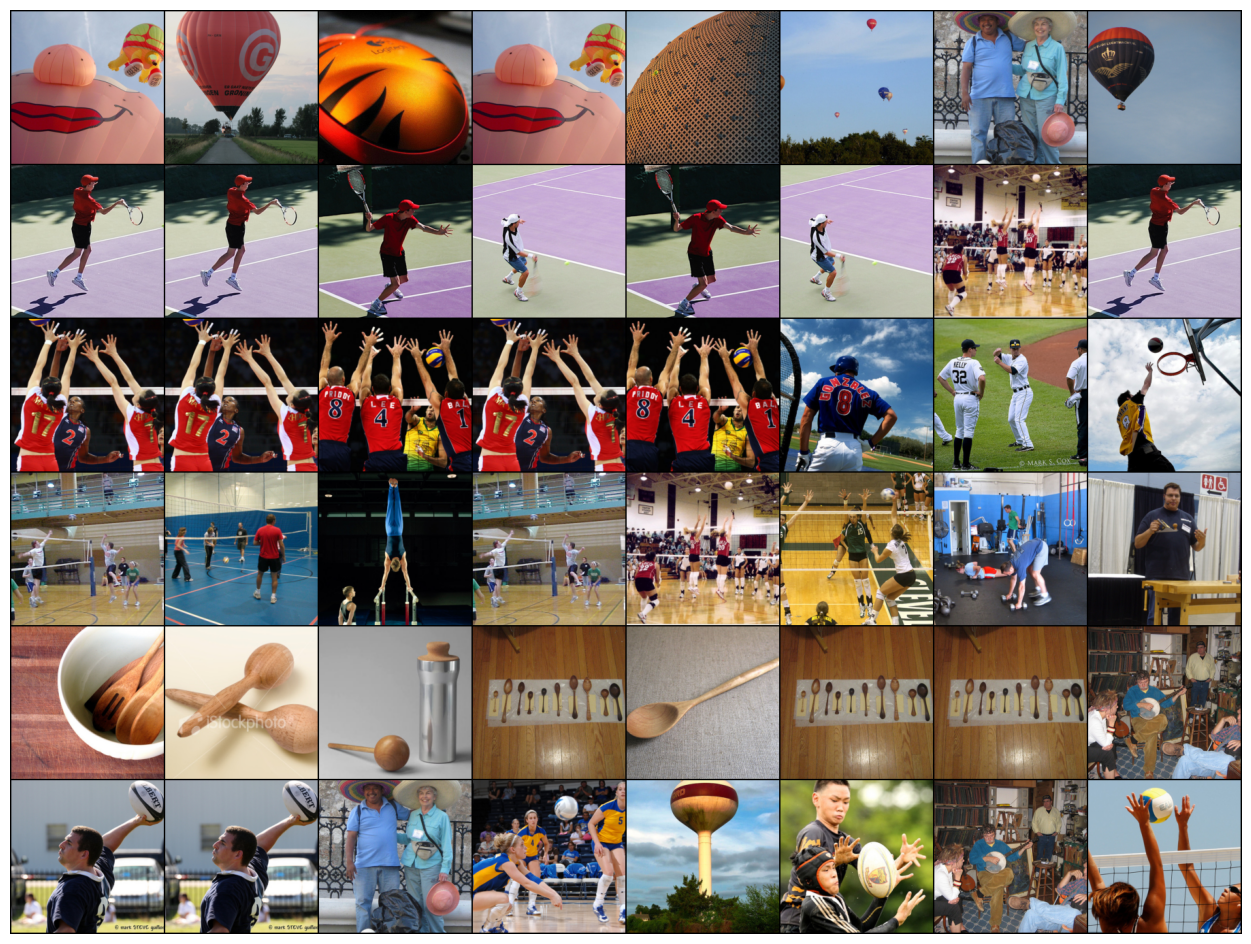

In [21]:
# show the full images where the patches above are extracted from (each patch is extracted from the corresponding image,
# i.e. we have an image grid with grid width of 8 and height of 6 so e.g. the patch in the above image at position (2, 3)
# would come somewhere from the image below that is at position (2, 3) in the grid below)
# note that while the model does not predict the class_to_explain class as majority class for any of them,
# class_to_explain may be the actual ground truth class (we only filter by the model's prediction and ignore the actual ground truth,
# since we want to explain the behavior of the model and not the labeling)

img_grid = torchvision.utils.make_grid(full_imgs)

fig = plt.figure(figsize=(16, 12))

plt.axis('off')
plt.imshow(img_grid.cpu().permute(1, 2, 0))

torch.Size([8, 3, 444, 74])
torch.Size([3, 1344, 448])
torch.Size([3, 1344, 224])


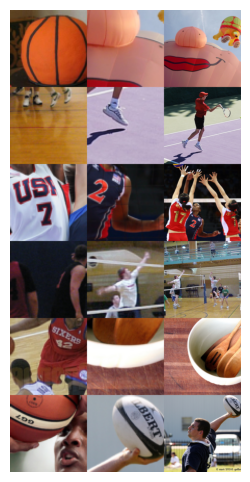

In [22]:
# combine the first six prototypes for basketball with the first six while excluding basketball in the images and the six images those patches were cropped from
# this image is shown in the paper

print(unnormalized_concept_patches_.shape)

imgs = torch.cat([unnormalized_concept_patches_[0].unsqueeze(dim=0), unnormalized_concept_patches_non_target], dim=-1)
#print(imgs.shape)


full_imgs_first_row = torch.cat([full_imgs[i*8] for i in range(6)], dim=1)
imgs = F.interpolate(imgs, (full_imgs_first_row.shape[1], 2*full_imgs_first_row.shape[2]))[0]

#imgs = torch.cat([imgs[0], imgs[1]], dim=-1)

print(imgs.shape)
print(full_imgs_first_row.shape)

imgs = torch.cat([imgs, full_imgs_first_row], dim=-1).unsqueeze(dim=0)


img_grid = torchvision.utils.make_grid(imgs)

fig = plt.figure(figsize=(3, 6))

plt.axis('off')
plt.imshow(imgs[0].cpu().permute(1, 2, 0))

#print(full_imgs.shape)